## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [5]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [3]:
#%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import math
import pandas as pd

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

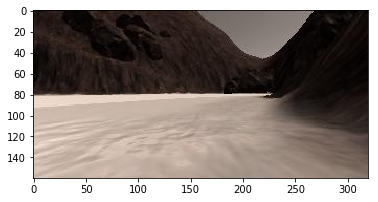

In [4]:
path = r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)
plt.show()

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

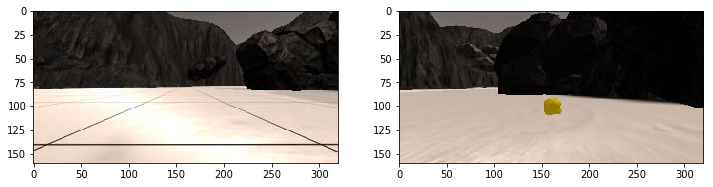

In [6]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samp000les with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\calibration_images\example_grid1.jpg'
example_rock = r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\calibration_images\example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)
plt.show()
scipy.misc.imsave(r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\code\RoboND-Python-StarterKit\RoboND-Python-StarterKit\Trial1\code\Test_Images\rock_sample.jpg',rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

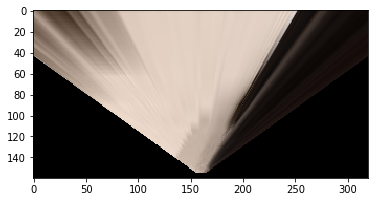

In [7]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
plt.imshow(warped)
plt.show()
scipy.misc.imsave(r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\calibration_images\warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

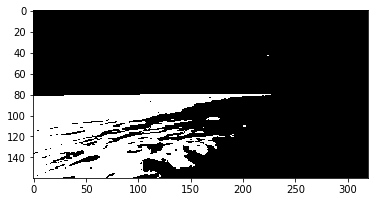

In [11]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(image)
plt.imshow(threshed, cmap='gray')
scipy.misc.imsave(r'C:\Users\Aravindh96\Desktop\img\warped_threshed.jpg', threshed*255)
plt.show()

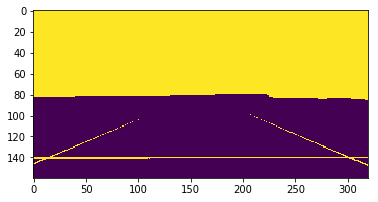

In [15]:
def obstacle_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
obstacle_threshed=obstacle_thresh(grid_img)
plt.imshow(obstacle_threshed)
plt.show()
scipy.misc.imsave(r"C:\Users\Aravindh96\Desktop\img\obstacle_sample.jpg",obstacle_threshed*255)

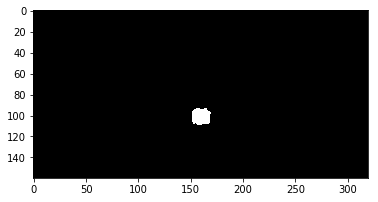

In [16]:
def rock_thresh(img, rgb_thresh=(75,250,50,50)):
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,1] > rgb_thresh[2]) \
                & (img[:,:,2] < rgb_thresh[3])
    color_select[above_thresh] = 1
    return color_select
rock_threshed=rock_thresh(rock_img)
plt.imshow(rock_threshed,cmap='gray')
plt.show()
scipy.misc.imsave(r"C:\Users\Aravindh96\Desktop\img\rock_sample.jpg",rock_threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

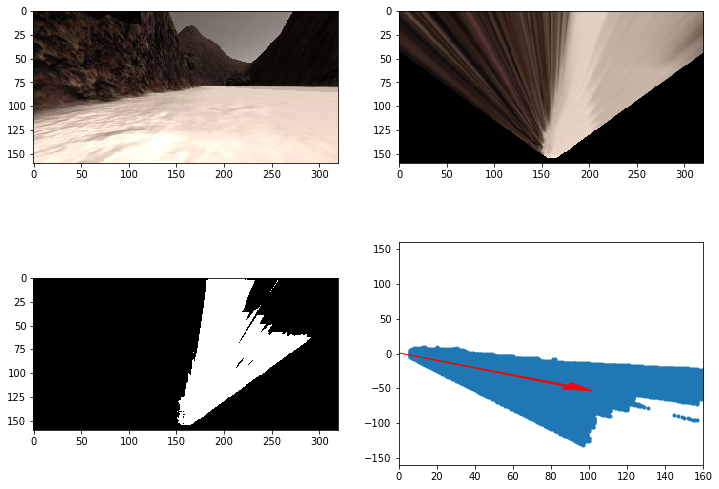

In [15]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    rad_angle=yaw*(math.pi/180)
    # Apply a rotation   
    xpix_rotated = (math.cos(rad_angle)*xpix) - (math.sin(rad_angle)*ypix)
    ypix_rotated = (math.sin(rad_angle)*xpix) + (math.cos(rad_angle)*ypix)
   
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated =(xpos + (xpix_rot/scale))
    ypix_translated =( ypos + (ypix_rot/scale)) 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()



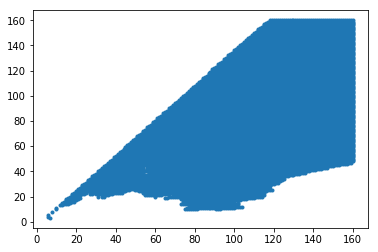

In [34]:
plt.plot(xpix, ypix, '.')

plt.show()

## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [81]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv(r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master/output/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth and create a 3-channel image with                                  
ground_truth = mpimg.imread(r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master/calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -2# This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.ones((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d# Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [88]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    image=mpimg.imread(data.images[data.count])
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    warped=perspect_transform(image,source,destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed=color_thresh(warped,(160,160,160))
    obstacle_threshed=obstacle_thresh(warped)
    rock_threshed=rock_thresh(warped)
    # 4) Convert thresholded image pixel values to rover-centric coords
    xpixel,ypixel=rover_coords(threshed)
    xpixel_obstacle,ypixel_obstacle=rover_coords(obstacle_threshed)
    xpixel_rock,ypixel_rock=rover_coords(rock_threshed)
    # 5) Convert rover-centric pixel values to world coords
    xpos=data.xpos[data.count]
    ypos=data.ypos[data.count]
    yaw=data.yaw[data.count]
    xpix_world,ypix_world=pix_to_world(xpixel,ypixel,xpos,ypos,yaw,200,10)
    
    xpix_world_obstacle,ypix_world_obstacle=pix_to_world(xpixel_obstacle,ypixel_obstacle,xpos,ypos,yaw,200,10)
    
    xpix_world_rock,ypix_world_rock=pix_to_world(xpixel_rock,ypixel_rock,xpos,ypos,yaw,200,10)
    
    # 6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[ypix_world,xpix_world,2]=255
    
    data.worldmap[ypix_world_obstacle,xpix_world_obstacle,2]=255
    
    data.worldmap[ypix_world_rock,xpix_world_rock,2]=255

      
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = image

        # Let's create more images to add to the mosaic, first a warped image
    
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 0.5, data.ground_truth, 1, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Dat nnnsdfsssd
    
    return output_image

87.53974 82.52504 139.5722


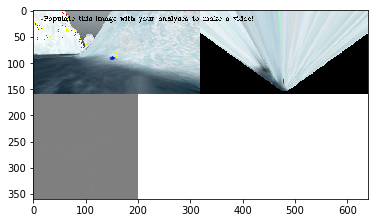

In [20]:
out=process_image(image)
plt.imshow(out)
plt.show()

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [89]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = r'C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\test_dataset/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

104.4762 188.6435 289.9771
[MoviePy] >>>> Building video C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\test_dataset/test_mapping.mp4
[MoviePy] Writing video C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\test_dataset/test_mapping.mp4


  0%|                                                                                          | 0/722 [00:00<?, ?it/s]

104.4762 188.6435 289.4682
99.66999 85.58897 46.8047


  0%|▏                                                                                 | 2/722 [00:00<00:37, 19.40it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  1%|▋                                                                                 | 6/722 [00:00<00:32, 21.81it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  1%|█                                                                                | 10/722 [00:00<00:29, 23.85it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  2%|█▍                                                                               | 13/722 [00:00<00:28, 25.29it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  2%|█▊                                                                               | 16/722 [00:00<00:27, 25.38it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  3%|██▏                                                                              | 19/722 [00:00<00:26, 26.06it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  3%|██▍                                                                              | 22/722 [00:00<00:26, 26.41it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  3%|██▊                                                                              | 25/722 [00:00<00:26, 26.80it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  4%|███▏                                                                             | 28/722 [00:01<00:25, 27.47it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  4%|███▍                                                                             | 31/722 [00:01<00:25, 27.48it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  5%|███▉                                                                             | 35/722 [00:01<00:23, 28.66it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  5%|████▎                                                                            | 38/722 [00:01<00:23, 28.96it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  6%|████▌                                                                            | 41/722 [00:01<00:23, 29.17it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  6%|████▉                                                                            | 44/722 [00:01<00:23, 28.81it/s]

99.66999 85.58897 46.8047
99.66999 85.58897 46.8047
99.66999 85.58897 46.8047


  7%|█████▎                                                                           | 47/722 [00:01<00:24, 27.62it/s]

99.67052 85.58955 46.80473
99.67122 85.59029 46.79659
99.67227 85.59141 46.86504


  7%|█████▌                                                                           | 50/722 [00:01<00:24, 27.47it/s]

99.67475 85.59406 46.77615
99.67802 85.59752 46.71368
99.68403 85.6039 46.63948


  7%|█████▉                                                                           | 53/722 [00:01<00:24, 27.22it/s]

99.68976 85.60993 46.67162
99.70065 85.62141 46.51995
99.7093 85.6305 46.51149


  8%|██████▎                                                                          | 56/722 [00:02<00:24, 27.64it/s]

99.72396 85.64582 46.43221
99.73392 85.65614 46.4762
99.74772 85.67041 46.53514


  8%|██████▌                                                                          | 59/722 [00:02<00:23, 27.63it/s]

99.75771 85.68087 46.50108
99.7755 85.69949 46.466
99.78886 85.71345 46.44521


  9%|██████▉                                                                          | 62/722 [00:02<00:24, 27.22it/s]

99.81123 85.73687 46.48333
99.82812 85.75452 46.4314
99.85489 85.78252 46.36234


  9%|███████▎                                                                         | 65/722 [00:02<00:23, 27.38it/s]

99.8735 85.80188 46.52036
99.90198 85.83155 46.67031
99.92188 85.85242 46.6535


  9%|███████▋                                                                         | 68/722 [00:02<00:24, 27.12it/s]

99.95446 85.88651 46.47066
99.97729 85.91035 46.41854
100.0134 85.94807 46.48967


 10%|███████▉                                                                         | 71/722 [00:02<00:24, 26.86it/s]

100.0384 85.97427 46.48119
100.078 86.01563 46.47521
100.1055 86.04436 46.47094


 10%|████████▎                                                                        | 74/722 [00:02<00:23, 27.51it/s]

100.1483 86.08908 46.4836
100.1778 86.11987 46.51352
100.2239 86.16811 46.45433


 11%|████████▋                                                                        | 77/722 [00:02<00:23, 27.28it/s]

100.2557 86.2013 46.42683
100.305 86.25277 46.38228
100.339 86.28822 46.35414


 11%|████████▉                                                                        | 80/722 [00:02<00:23, 27.50it/s]

100.3917 86.34312 46.3243
100.4279 86.38071 46.31962
100.484 86.43903 46.28863


 11%|█████████▎                                                                       | 83/722 [00:02<00:23, 27.35it/s]

100.5224 86.47894 46.28044
100.5817 86.5405 46.26382
100.6224 86.58271 46.25335


 12%|█████████▋                                                                       | 86/722 [00:03<00:23, 27.47it/s]

100.6851 86.64764 46.24137
100.7279 86.69207 46.23322
100.7938 86.76033 46.22297


 12%|█████████▉                                                                       | 89/722 [00:03<00:23, 27.25it/s]

100.8389 86.80694 46.21495
100.9081 86.87857 46.2033
100.9552 86.92738 46.19553


 13%|██████████▎                                                                      | 92/722 [00:03<00:23, 27.03it/s]

101.0276 87.0023 46.18427
101.077 87.0533 46.1771
101.1526 87.13145 46.16566


 13%|██████████▋                                                                      | 95/722 [00:03<00:23, 27.02it/s]

101.204 87.18462 46.15879
101.2828 87.26603 46.14783
101.3364 87.32133 46.14053


 14%|██████████▉                                                                      | 98/722 [00:03<00:23, 26.87it/s]

101.4184 87.40595 46.13012
101.4741 87.46346 46.12146
101.5592 87.55124 46.11037


 14%|███████████▏                                                                    | 101/722 [00:03<00:23, 26.31it/s]

101.617 87.61082 46.10429
101.7052 87.70177 46.09328
101.7651 87.76347 46.08445


 14%|███████████▌                                                                    | 104/722 [00:03<00:22, 26.91it/s]

101.8565 87.85764 46.07296
101.9184 87.92142 46.06609
102.0129 88.01871 46.05419


 15%|███████████▊                                                                    | 107/722 [00:03<00:23, 26.58it/s]

102.0769 88.08456 46.04719
102.1745 88.18494 46.03507
102.2406 88.25291 46.02754


 15%|████████████▏                                                                   | 110/722 [00:04<00:23, 26.35it/s]

102.3412 88.35635 46.01683
102.4093 88.42635 46.00851
102.513 88.5329 45.9969


 16%|████████████▌                                                                   | 113/722 [00:04<00:22, 26.98it/s]

102.5832 88.60497 45.98933
102.69 88.71458 45.97814
102.7621 88.78858 45.97088


 16%|████████████▊                                                                   | 116/722 [00:04<00:21, 27.66it/s]

102.8718 88.90114 45.95811
102.9461 88.97729 45.94984
103.059 89.09298 45.93659


 16%|█████████████▏                                                                  | 119/722 [00:04<00:21, 27.72it/s]

103.1351 89.171 45.92871
103.2508 89.28954 45.91554
103.3291 89.36966 45.90696


 17%|█████████████▌                                                                  | 122/722 [00:04<00:21, 27.39it/s]

103.4479 89.49126 45.89321
103.5281 89.5733 45.88496
103.65 89.69759 45.81878


 17%|█████████████▊                                                                  | 125/722 [00:04<00:21, 27.50it/s]

103.7328 89.78087 45.64669
103.8597 89.90568 45.06787
103.9465 89.98852 44.4777


 18%|██████████████▏                                                                 | 128/722 [00:04<00:21, 27.42it/s]

104.0809 90.11073 43.22221
104.1723 90.19153 42.33448
104.3115 90.31288 41.24718


 18%|██████████████▌                                                                 | 131/722 [00:04<00:21, 27.26it/s]

104.4061 90.39394 40.71411
104.55 90.51687 40.27866
104.6471 90.6 40.17712


 19%|██████████████▊                                                                 | 134/722 [00:04<00:22, 26.28it/s]

104.7947 90.72624 40.14676
104.8943 90.8114 40.15483
105.0455 90.9406 40.17899


 19%|███████████████▏                                                                | 137/722 [00:04<00:21, 26.74it/s]

105.1474 91.02773 40.19698
105.302 91.15993 40.22971
105.4062 91.24905 40.2505


 19%|███████████████▌                                                                | 140/722 [00:05<00:22, 26.25it/s]

105.5643 91.38384 40.27272
105.6707 91.47373 40.26486
105.8313 91.60897 40.25115


 20%|███████████████▊                                                                | 143/722 [00:05<00:21, 26.90it/s]

105.9394 91.69981 40.23964
106.1034 91.83747 40.21991
106.2139 91.93009 40.20393
106.3811 92.07021 40.1839


 20%|████████████████▎                                                               | 147/722 [00:05<00:20, 28.19it/s]

106.4935 92.16435 40.17176
106.6638 92.30681 40.15434
106.7783 92.40259 40.14259


 21%|████████████████▌                                                               | 150/722 [00:05<00:20, 27.51it/s]

106.9516 92.54744 40.1234
107.0681 92.64482 40.11106
107.2444 92.79205 40.09136


 21%|████████████████▉                                                               | 153/722 [00:05<00:21, 27.06it/s]

107.3631 92.89104 40.07954
107.5424 93.04057 40.05823
107.663 93.14104 40.02927


 22%|█████████████████▎                                                              | 156/722 [00:05<00:21, 26.72it/s]

107.8463 93.29184 39.76032
107.9701 93.39211 39.40933
108.1589 93.54133 38.53979


 22%|█████████████████▌                                                              | 159/722 [00:05<00:21, 26.56it/s]

108.2868 93.64011 37.88903
108.4808 93.78839 37.13246
108.6115 93.88748 36.80192


 22%|█████████████████▉                                                              | 162/722 [00:05<00:21, 26.06it/s]

108.8092 94.03722 36.60653
108.9423 94.13765 36.57311
109.1435 94.28934 36.57475


 23%|██████████████████▎                                                             | 165/722 [00:06<00:21, 26.51it/s]

109.2788 94.39121 36.59084
109.4836 94.54524 36.62578
109.6211 94.6488 36.65271


 23%|██████████████████▌                                                             | 168/722 [00:06<00:20, 26.77it/s]

109.8295 94.80456 36.56641
109.97 94.90809 36.35926
110.1832 95.06207 35.71729


 24%|██████████████████▉                                                             | 171/722 [00:06<00:20, 26.59it/s]

110.3275 95.16309 35.07251
110.5465 95.31257 34.00965
110.6943 95.41124 33.39173


 24%|███████████████████▎                                                            | 174/722 [00:06<00:20, 26.46it/s]

110.9182 95.55883 32.7564
111.0689 95.65726 32.52871
111.2971 95.8054 32.40224


 25%|███████████████████▌                                                            | 177/722 [00:06<00:20, 26.70it/s]

111.4507 95.90458 32.38242
111.683 96.05421 32.38744
111.839 96.15466 32.40441


 25%|███████████████████▉                                                            | 180/722 [00:06<00:20, 26.79it/s]

112.075 96.30636 32.43364
112.2335 96.40826 32.45559
112.4731 96.56228 32.49054


 25%|████████████████████▎                                                           | 183/722 [00:06<00:20, 26.78it/s]

112.6339 96.66576 32.51495
112.8767 96.82214 32.55335
113.0398 96.92679 32.52059


 26%|████████████████████▌                                                           | 186/722 [00:06<00:20, 26.42it/s]

113.2869 97.08311 32.22013
113.4532 97.1865 31.84053
113.705 97.33896 30.92703


 26%|████████████████████▉                                                           | 189/722 [00:06<00:19, 26.74it/s]

113.8749 97.4381 30.10212
114.1333 97.58138 28.51375
114.3078 97.67274 27.24773


 27%|█████████████████████▎                                                          | 192/722 [00:07<00:19, 26.67it/s]

114.5727 97.80283 25.16566
114.7509 97.8843 23.73273
115.0201 97.99816 21.56593


 27%|█████████████████████▌                                                          | 195/722 [00:07<00:20, 26.11it/s]

115.2019 98.07021 20.28286
115.479 98.17656 18.78485
115.6668 98.24636 17.99435


 27%|█████████████████████▉                                                          | 198/722 [00:07<00:19, 26.23it/s]

115.9539 98.34821 17.07215
116.1485 98.4109 16.38573
116.4386 98.50079 15.62064


 28%|██████████████████████▎                                                         | 201/722 [00:07<00:19, 26.49it/s]

116.6325 98.55758 15.28851
116.9254 98.63748 14.82156
117.1209 98.68842 14.41974


 28%|██████████████████████▌                                                         | 204/722 [00:07<00:19, 26.43it/s]

117.4132 98.76124 13.48063
117.609 98.80572 12.6826
117.9005 98.87027 11.45367


 29%|██████████████████████▉                                                         | 207/722 [00:07<00:19, 26.15it/s]

118.096 98.91001 10.90733
118.3897 98.96743 10.38454
118.5859 99.00494 10.20374


 29%|███████████████████████▎                                                        | 210/722 [00:07<00:19, 26.40it/s]

118.8806 99.06101 10.19885
119.0774 99.09895 10.37633
119.3732 99.15848 10.97963


 30%|███████████████████████▌                                                        | 213/722 [00:07<00:19, 26.58it/s]

119.5705 99.20071 11.59301
119.8653 99.26961 12.89742
120.0609 99.31941 13.94716


 30%|███████████████████████▉                                                        | 216/722 [00:07<00:19, 26.49it/s]

120.3517 99.39993 15.76393
120.5431 99.45663 17.11858
120.8255 99.54713 19.31043


 30%|████████████████████████▎                                                       | 219/722 [00:08<00:19, 26.37it/s]

121.0103 99.61179 20.80055
121.2832 99.71313 22.72067
121.4642 99.78379 23.82536


 31%|████████████████████████▌                                                       | 222/722 [00:08<00:19, 25.90it/s]

121.7366 99.89749 25.36903
121.9189 99.97847 26.39254
122.1931 100.1097 28.08017


 31%|████████████████████████▉                                                       | 225/722 [00:08<00:19, 25.75it/s]

122.3744 100.2067 29.49933
122.6381 100.3628 31.85167
122.8091 100.4704 33.48865


 32%|█████████████████████████▎                                                      | 228/722 [00:08<00:19, 25.98it/s]

123.0581 100.6376 35.94809
123.2201 100.7514 37.38047
123.4566 100.9269 39.34115


 32%|█████████████████████████▌                                                      | 231/722 [00:08<00:19, 25.84it/s]

123.6092 101.0495 40.81239
123.8352 101.2441 42.68921
123.9837 101.3795 43.76636


 32%|█████████████████████████▉                                                      | 234/722 [00:08<00:19, 25.61it/s]

124.2023 101.5898 45.39721
124.3439 101.7318 46.43113
124.5518 101.947 47.83953


 33%|██████████████████████████▎                                                     | 237/722 [00:08<00:18, 25.74it/s]

124.6864 102.094 48.59315
124.8859 102.319 49.33329
125.0176 102.4704 49.65382


 33%|██████████████████████████▌                                                     | 240/722 [00:08<00:18, 25.81it/s]

125.2128 102.6988 50.16127
125.3407 102.8524 50.6185
125.5283 103.0861 51.57348


 34%|██████████████████████████▉                                                     | 243/722 [00:09<00:18, 26.05it/s]

125.6509 103.2439 52.37512
125.8301 103.4841 53.87275
125.9463 103.6465 55.02394


 34%|███████████████████████████▎                                                    | 246/722 [00:09<00:17, 26.68it/s]

126.1151 103.894 56.86794
126.2233 104.0619 58.13576
126.3777 104.3182 60.08652


 34%|███████████████████████████▌                                                    | 249/722 [00:09<00:17, 27.03it/s]

126.478 104.4906 61.35859
126.6193 104.754 63.33828
126.7082 104.9323 64.64027


 35%|███████████████████████████▉                                                    | 252/722 [00:09<00:17, 26.59it/s]

126.8354 105.2014 66.58765
126.9137 105.3832 67.87181
127.0249 105.6599 69.60944


 35%|████████████████████████████▎                                                   | 255/722 [00:09<00:17, 26.26it/s]

127.0958 105.8457 70.6214
127.1963 106.1281 71.90856
127.2594 106.3181 72.59257


 36%|████████████████████████████▌                                                   | 258/722 [00:09<00:18, 25.50it/s]

127.3503 106.6044 73.31327
127.4093 106.7959 73.59801
127.4963 107.0839 73.79546


 36%|████████████████████████████▉                                                   | 261/722 [00:09<00:18, 25.28it/s]

127.5535 107.2767 73.85349
127.6378 107.5667 74.00072
127.6929 107.7605 74.21548


 37%|█████████████████████████████▎                                                  | 264/722 [00:09<00:18, 25.38it/s]

127.7725 108.052 74.82478
127.8229 108.2471 75.44969
127.8933 108.5396 76.73224


 37%|█████████████████████████████▌                                                  | 267/722 [00:09<00:18, 24.94it/s]

127.9367 108.7337 77.82732
127.993 109.0258 79.92401
128.0247 109.2206 81.30922


 37%|█████████████████████████████▉                                                  | 270/722 [00:10<00:18, 24.99it/s]

128.0668 109.5147 83.19308
128.0912 109.7139 84.30684
128.1212 110.0146 86.05232


 38%|██████████████████████████████▏                                                 | 273/722 [00:10<00:17, 25.08it/s]

128.1365 110.2134 87.33009
128.1499 110.5122 89.29723
128.1509 110.7123 90.65189


 38%|██████████████████████████████▌                                                 | 276/722 [00:10<00:17, 25.02it/s]

128.1455 111.0119 92.61685
128.1377 111.2119 93.86267
128.1174 111.5112 95.49652


 39%|██████████████████████████████▉                                                 | 279/722 [00:10<00:17, 25.20it/s]

128.0992 111.7105 96.39597
128.0676 112.009 97.42767
128.0435 112.208 97.92746


 39%|███████████████████████████████▏                                                | 282/722 [00:10<00:17, 25.42it/s]

128.0036 112.5062 98.43356
127.9743 112.7047 98.78104
127.9266 113.0015 99.51395


 39%|███████████████████████████████▌                                                | 285/722 [00:10<00:17, 25.48it/s]

127.8921 113.1986 100.1556
127.8351 113.4927 101.4128
127.7934 113.6882 102.399


 40%|███████████████████████████████▉                                                | 288/722 [00:10<00:17, 24.67it/s]

127.7253 113.9802 104.1099
127.6753 114.1739 105.3636
127.5924 114.4621 107.3226


 40%|████████████████████████████████▏                                               | 291/722 [00:10<00:17, 24.49it/s]

127.5321 114.6527 108.631
127.4341 114.9359 110.6136
127.3639 115.1232 111.9227


 41%|████████████████████████████████▌                                               | 294/722 [00:11<00:17, 24.98it/s]

127.2504 115.4006 113.9077
127.1701 115.5833 115.1461
127.0429 115.8553 116.7401


 41%|████████████████████████████████▉                                               | 297/722 [00:11<00:18, 23.02it/s]

126.9539 116.0346 117.639
126.8158 116.3013 118.6704
126.7212 116.4778 119.1642


 42%|█████████████████████████████████▏                                              | 300/722 [00:11<00:17, 23.97it/s]

126.5766 116.7413 119.5825
126.4788 116.9166 119.7122
126.3307 117.1794 119.794


 42%|█████████████████████████████████▌                                              | 303/722 [00:11<00:17, 24.63it/s]

126.2313 117.3546 119.8144
126.0812 117.618 119.836
125.9812 117.7937 119.8377


 42%|█████████████████████████████████▉                                              | 306/722 [00:11<00:16, 24.52it/s]

125.8311 118.0572 119.8278
125.7309 118.233 119.8215
125.5803 118.4971 119.8115


 43%|██████████████████████████████████▏                                             | 309/722 [00:11<00:16, 25.00it/s]

125.4799 118.6732 119.7958
125.3295 118.9376 119.7632
125.2292 119.114 119.7345


 43%|██████████████████████████████████▌                                             | 312/722 [00:11<00:16, 25.31it/s]

125.0782 119.378 119.7155
124.9773 119.5528 119.7299
124.8286 119.8118 119.7119


 44%|██████████████████████████████████▉                                             | 315/722 [00:11<00:16, 25.43it/s]

124.7296 119.9854 119.7028
124.5814 120.2463 119.685
124.4826 120.4205 119.6696


 44%|███████████████████████████████████▏                                            | 318/722 [00:11<00:15, 25.26it/s]

124.3345 120.6822 119.6359
124.2357 120.8569 119.6184
124.0877 121.1195 119.5975


 44%|███████████████████████████████████▌                                            | 321/722 [00:12<00:15, 25.12it/s]

123.9892 121.2943 119.5623
123.8414 121.5573 119.5326
123.7429 121.7328 119.5136


 45%|███████████████████████████████████▉                                            | 324/722 [00:12<00:15, 25.33it/s]

123.5957 121.9954 119.453
123.4979 122.1702 119.4246
123.3518 122.4315 119.3861


 45%|████████████████████████████████████▏                                           | 327/722 [00:12<00:15, 25.39it/s]

123.2543 122.6063 119.3621
123.108 122.8689 119.3333
123.0104 123.0442 119.3185


 46%|████████████████████████████████████▌                                           | 330/722 [00:12<00:15, 25.78it/s]

122.8644 123.3069 119.2557
122.7669 123.4825 119.2356
122.6209 123.7459 119.1896


 46%|████████████████████████████████████▉                                           | 333/722 [00:12<00:14, 25.94it/s]

122.5236 123.9214 119.1437
122.3777 124.1854 119.1075
122.2806 124.3615 119.0819


 47%|█████████████████████████████████████▏                                          | 336/722 [00:12<00:14, 26.04it/s]

122.1355 124.6249 119.052
122.0394 124.7994 119.0508
121.8948 125.0625 119.0154


 47%|█████████████████████████████████████▌                                          | 339/722 [00:12<00:14, 25.95it/s]

121.7983 125.2381 118.993
121.6538 125.5015 118.9554
121.5573 125.6776 118.9342


 47%|█████████████████████████████████████▉                                          | 342/722 [00:12<00:14, 26.19it/s]

121.4127 125.9417 118.899
121.3163 126.1179 118.874
121.1719 126.3823 118.8289


 48%|██████████████████████████████████████▏                                         | 345/722 [00:13<00:14, 26.43it/s]

121.0756 126.5588 118.8058
120.9312 126.8239 118.7797
120.8352 127.0003 118.7778


 48%|██████████████████████████████████████▌                                         | 348/722 [00:13<00:14, 26.42it/s]

120.6919 127.2642 118.4918
120.5965 127.4409 118.4641
120.4538 127.7058 118.3983


 49%|██████████████████████████████████████▉                                         | 351/722 [00:13<00:14, 26.42it/s]

120.3591 127.8819 118.3561
120.2174 128.1468 118.3021
120.1231 128.3235 118.271


 49%|███████████████████████████████████████▏                                        | 354/722 [00:13<00:14, 26.18it/s]

119.9814 128.5893 118.2823
119.8876 128.7657 118.1458
119.7464 129.0318 118.1213


 49%|███████████████████████████████████████▌                                        | 357/722 [00:13<00:13, 26.39it/s]

119.6524 129.2094 118.11
119.5118 129.4753 117.9754
119.4181 129.6533 117.9541


 50%|███████████████████████████████████████▉                                        | 360/722 [00:13<00:13, 25.91it/s]

119.2784 129.9189 117.9054
119.1852 130.0965 117.8755
119.0456 130.363 117.8356


 50%|████████████████████████████████████████▏                                       | 363/722 [00:13<00:13, 26.16it/s]

118.9526 130.5408 117.8107
118.8133 130.8078 117.7735
118.7204 130.9859 117.749


 51%|████████████████████████████████████████▌                                       | 366/722 [00:13<00:13, 26.31it/s]

118.5825 131.2508 117.7042
118.4903 131.4281 117.681
118.3521 131.6943 117.6436


 51%|████████████████████████████████████████▉                                       | 369/722 [00:13<00:13, 26.27it/s]

118.2599 131.872 117.6172
118.1216 132.1389 117.5685
118.0293 132.3171 117.5463


 52%|█████████████████████████████████████████▏                                      | 372/722 [00:14<00:13, 26.59it/s]

117.8909 132.5849 117.5255
117.7988 132.7632 117.4834
117.6606 133.0314 117.4546


 52%|█████████████████████████████████████████▌                                      | 375/722 [00:14<00:13, 26.43it/s]

117.5685 133.2104 117.4368
117.4306 133.4786 117.3907
117.3387 133.6577 117.3692


 52%|█████████████████████████████████████████▉                                      | 378/722 [00:14<00:13, 26.22it/s]

117.2015 133.9253 117.3289
117.111 134.1022 117.2922
116.9744 134.3697 117.2599


 53%|██████████████████████████████████████████▏                                     | 381/722 [00:14<00:13, 26.14it/s]

116.8833 134.5482 117.2412
116.7469 134.8159 117.1742
116.6559 134.9949 117.153


 53%|██████████████████████████████████████████▌                                     | 384/722 [00:14<00:12, 26.43it/s]

116.5195 135.2634 117.1141
116.4286 135.4425 117.0837
116.2923 135.7116 117.0487


 54%|██████████████████████████████████████████▉                                     | 387/722 [00:14<00:13, 25.64it/s]

116.2016 135.891 117.0243
116.0654 136.1607 117.0084
115.9755 136.339 116.9733


 54%|███████████████████████████████████████████▏                                    | 390/722 [00:14<00:12, 26.04it/s]

115.8408 136.6066 116.9618
115.7508 136.7854 116.9377
115.6159 137.0537 116.904


 54%|███████████████████████████████████████████▌                                    | 393/722 [00:14<00:12, 26.36it/s]

115.526 137.2328 116.884
115.3909 137.5019 116.8511
115.3009 137.6814 116.8286


 55%|███████████████████████████████████████████▉                                    | 396/722 [00:14<00:12, 26.24it/s]

115.1658 137.9512 116.8022
115.0762 138.1304 116.7661
114.9414 138.4003 116.7347


 55%|████████████████████████████████████████████▏                                   | 399/722 [00:15<00:12, 26.25it/s]

114.8516 138.5804 116.7147
114.7176 138.8498 116.6889
114.6287 139.0285 116.6716


 56%|████████████████████████████████████████████▌                                   | 402/722 [00:15<00:12, 26.37it/s]

114.4952 139.2973 116.6351
114.4062 139.4766 116.6114
114.2726 139.7461 116.5784


 56%|████████████████████████████████████████████▉                                   | 405/722 [00:15<00:12, 26.14it/s]

114.1837 139.9256 116.5545
114.0502 140.1955 116.5228
113.9612 140.3757 116.5027


 57%|█████████████████████████████████████████████▏                                  | 408/722 [00:15<00:12, 25.95it/s]

113.8282 140.6456 116.4106
113.74 140.8263 116.2596
113.6097 141.0982 115.7594


 57%|█████████████████████████████████████████████▌                                  | 411/722 [00:15<00:11, 26.16it/s]

113.5244 141.2802 115.2518
113.4 141.5538 114.1609
113.3215 141.7368 113.248


 57%|█████████████████████████████████████████████▊                                  | 414/722 [00:15<00:11, 26.13it/s]

113.2099 142.0131 111.4976
113.1396 142.1969 110.128
113.0438 142.4755 108.0041


 58%|██████████████████████████████████████████████▏                                 | 417/722 [00:15<00:11, 26.39it/s]

112.9849 142.6614 106.5683
112.9055 142.9419 104.4138
112.8553 143.1316 103.1825


 58%|██████████████████████████████████████████████▌                                 | 420/722 [00:15<00:11, 26.36it/s]

112.7821 143.4209 101.6438
112.7362 143.6166 100.7703
112.6714 143.9137 99.70404


 59%|██████████████████████████████████████████████▊                                 | 423/722 [00:16<00:11, 25.08it/s]

112.6337 144.1138 98.81628
112.5841 144.4131 97.82431
112.5545 144.6126 97.42224


 59%|███████████████████████████████████████████████▏                                | 426/722 [00:16<00:11, 25.34it/s]

112.5127 144.9122 97.13715
112.4863 145.1124 97.05579
112.4474 145.4129 97.00247


 59%|███████████████████████████████████████████████▌                                | 429/722 [00:16<00:11, 25.42it/s]

112.4219 145.6135 96.9899
112.3835 145.9137 97.04373
112.3578 146.1137 97.09897


 60%|███████████████████████████████████████████████▊                                | 432/722 [00:16<00:11, 25.52it/s]

112.3192 146.4147 97.1127
112.2934 146.6147 97.19083
112.2549 146.9158 97.21017


 60%|████████████████████████████████████████████████▏                               | 435/722 [00:16<00:11, 25.16it/s]

112.2304 147.1167 97.18713
112.1941 147.4158 97.17889
112.1699 147.6139 97.16028


 61%|████████████████████████████████████████████████▌                               | 438/722 [00:16<00:11, 25.69it/s]

112.1344 147.9077 97.11588
112.1105 148.1057 97.09354
112.0747 148.4032 97.06668


 61%|████████████████████████████████████████████████▊                               | 441/722 [00:16<00:10, 25.60it/s]

112.0508 148.6019 97.0535
112.015 148.9003 96.9696
111.9912 149.0993 96.84756


 61%|█████████████████████████████████████████████████▏                              | 444/722 [00:16<00:10, 25.81it/s]

111.9558 149.3986 96.81012
111.9324 149.5982 96.77951
111.8975 149.8976 96.69775


 62%|█████████████████████████████████████████████████▌                              | 447/722 [00:16<00:10, 26.05it/s]

111.8744 150.0976 96.67911
111.8401 150.398 96.68195
111.8174 150.5977 96.60223


 62%|█████████████████████████████████████████████████▊                              | 450/722 [00:17<00:10, 26.58it/s]

111.7837 150.8982 96.5777
111.7613 151.0985 96.56287
111.7282 151.3974 96.49567


 63%|██████████████████████████████████████████████████▏                             | 453/722 [00:17<00:10, 26.42it/s]

111.7064 151.5956 96.46741
111.6738 151.8939 96.43048
111.6522 152.0929 96.40576


 63%|██████████████████████████████████████████████████▌                             | 456/722 [00:17<00:09, 26.74it/s]

111.6199 152.392 96.38684
111.5984 152.5911 96.33096
111.5664 152.8906 96.30103


 64%|██████████████████████████████████████████████████▊                             | 459/722 [00:17<00:09, 26.64it/s]

111.5451 153.0904 96.28369
111.5134 153.3895 96.20755
111.4924 153.5895 96.18616


 64%|███████████████████████████████████████████████████▏                            | 462/722 [00:17<00:09, 26.57it/s]

111.4611 153.8894 96.14532
111.4404 154.089 96.10956
111.4097 154.3877 96.03116


 64%|███████████████████████████████████████████████████▌                            | 465/722 [00:17<00:09, 26.49it/s]

111.3893 154.5873 96.00201
111.359 154.8869 95.97617
111.339 155.0869 95.96704


 65%|███████████████████████████████████████████████████▊                            | 468/722 [00:17<00:09, 26.68it/s]

111.3093 155.3854 95.86105
111.2896 155.5836 95.83298
111.2603 155.8819 95.79718


 65%|████████████████████████████████████████████████████▏                           | 471/722 [00:17<00:09, 26.74it/s]

111.2409 156.081 95.77344
111.2118 156.3803 95.75513
111.1926 156.5795 95.70154


 66%|████████████████████████████████████████████████████▌                           | 474/722 [00:17<00:09, 27.04it/s]

111.1638 156.8793 95.67346
111.1446 157.0794 95.65744
111.1161 157.3793 95.60794


 66%|████████████████████████████████████████████████████▊                           | 477/722 [00:18<00:09, 26.60it/s]

111.0972 157.5795 95.58804
111.069 157.8797 95.54575
111.0504 158.0802 95.52429


 66%|█████████████████████████████████████████████████████▏                          | 480/722 [00:18<00:08, 26.90it/s]

111.0225 158.3806 95.48682
111.0042 158.5801 95.46219
110.977 158.8776 95.4147


 67%|█████████████████████████████████████████████████████▌                          | 483/722 [00:18<00:08, 26.64it/s]

110.9589 159.077 95.3931
110.9319 159.3763 95.34882
110.9139 159.5758 95.32397


 67%|█████████████████████████████████████████████████████▊                          | 486/722 [00:18<00:08, 26.72it/s]

110.8859 159.8756 95.49875
110.8659 160.0754 95.7767
110.8324 160.3746 96.51047


 68%|██████████████████████████████████████████████████████▏                         | 489/722 [00:18<00:08, 26.66it/s]

110.8076 160.5733 97.22739
110.7661 160.8689 98.73813
110.733 161.0626 99.83307


 68%|██████████████████████████████████████████████████████▌                         | 492/722 [00:18<00:08, 26.55it/s]

110.6771 161.3524 101.8358
110.6346 161.5437 103.2391
110.5633 161.8274 105.3956


 69%|██████████████████████████████████████████████████████▊                         | 495/722 [00:18<00:08, 26.30it/s]

110.5114 162.0157 106.7217
110.4285 162.3006 108.4846
110.3689 162.4918 109.6118


 69%|███████████████████████████████████████████████████████▏                        | 498/722 [00:18<00:08, 26.79it/s]

110.2717 162.7794 111.3133
110.2004 162.9694 112.6844
110.0835 163.247 115.1251


 69%|███████████████████████████████████████████████████████▌                        | 501/722 [00:18<00:08, 26.40it/s]

110.0001 163.4274 116.6948
109.869 163.6923 118.6811
109.7755 163.8683 119.7581


 70%|███████████████████████████████████████████████████████▊                        | 504/722 [00:19<00:08, 26.51it/s]

109.6285 164.1322 120.8572
109.5281 164.3064 121.376
109.3763 164.5656 121.8652


 70%|████████████████████████████████████████████████████████▏                       | 507/722 [00:19<00:08, 26.48it/s]

109.2724 164.737 122.0306
109.114 164.9934 122.136
109.0076 165.1643 122.163


 71%|████████████████████████████████████████████████████████▌                       | 510/722 [00:19<00:07, 26.60it/s]

108.8473 165.4211 122.175
108.7402 165.5924 122.1706
108.5788 165.8501 122.1741


 71%|████████████████████████████████████████████████████████▊                       | 513/722 [00:19<00:07, 26.90it/s]

108.4715 166.0218 122.1682
108.3106 166.2794 122.1487
108.2033 166.4513 122.1377


 71%|█████████████████████████████████████████████████████████▏                      | 516/722 [00:19<00:07, 26.82it/s]

108.042 166.7095 122.1119
107.9346 166.8817 122.0935
107.7734 167.1392 122.0488


 72%|█████████████████████████████████████████████████████████▌                      | 519/722 [00:19<00:07, 26.74it/s]

107.6657 167.3096 122.0624
107.5068 167.5619 122.0412
107.401 167.731 122.0319


 72%|█████████████████████████████████████████████████████████▊                      | 522/722 [00:19<00:07, 26.64it/s]

107.2421 167.9858 122.0172
107.1363 168.1559 122.006
106.9776 168.4114 121.9779


 73%|██████████████████████████████████████████████████████████▏                     | 525/722 [00:19<00:07, 26.82it/s]

106.8718 168.582 121.9527
106.7133 168.8381 121.8957
106.6076 169.0091 121.8735


 73%|██████████████████████████████████████████████████████████▌                     | 528/722 [00:19<00:07, 26.95it/s]

106.4492 169.266 121.8571
106.3439 169.437 121.8046
106.1858 169.6942 121.774


 74%|██████████████████████████████████████████████████████████▊                     | 531/722 [00:20<00:07, 26.68it/s]

106.0811 169.8648 121.7383
105.9247 170.1198 121.6921
105.8203 170.2905 121.6682


 74%|███████████████████████████████████████████████████████████▏                    | 534/722 [00:20<00:07, 26.81it/s]

105.6635 170.547 121.642
105.559 170.7182 121.6312
105.4025 170.9748 121.5514


 74%|███████████████████████████████████████████████████████████▌                    | 537/722 [00:20<00:06, 26.91it/s]

105.298 171.1463 121.5322
105.1416 171.4036 121.4817
105.0371 171.5755 121.4604


 75%|███████████████████████████████████████████████████████████▊                    | 540/722 [00:20<00:06, 26.83it/s]

104.8808 171.8333 121.4227
104.7766 172.0053 121.3947
104.621 172.2627 121.3723


 75%|████████████████████████████████████████████████████████████▏                   | 543/722 [00:20<00:06, 26.70it/s]

104.5178 172.4336 121.3753
104.3626 172.6906 121.3395
104.2591 172.8622 121.3157


 76%|████████████████████████████████████████████████████████████▍                   | 546/722 [00:20<00:06, 26.23it/s]

104.1041 173.1195 121.288
104.0005 173.2915 121.267
103.8453 173.5495 121.233


 76%|████████████████████████████████████████████████████████████▊                   | 549/722 [00:20<00:06, 26.39it/s]

103.7418 173.7216 121.2098
103.587 173.9796 121.1765
103.4843 174.1514 121.0954


 76%|█████████████████████████████████████████████████████████████▏                  | 552/722 [00:20<00:06, 26.43it/s]

103.332 174.4095 120.7426
103.2318 174.5818 120.3471
103.0853 174.8408 119.4633


 77%|█████████████████████████████████████████████████████████████▍                  | 555/722 [00:21<00:06, 26.32it/s]

102.9911 175.014 118.6913
102.8566 175.275 117.2233
102.7715 175.4497 116.0981


 77%|█████████████████████████████████████████████████████████████▊                  | 558/722 [00:21<00:06, 26.45it/s]

102.6497 175.7121 114.4683
102.5714 175.8861 113.4481
102.4533 176.1498 112.2997


 78%|██████████████████████████████████████████████████████████████▏                 | 561/722 [00:21<00:06, 26.51it/s]

102.375 176.3272 111.6873
102.2602 176.5958 111.0457
102.1866 176.7774 110.7466


 78%|██████████████████████████████████████████████████████████████▍                 | 564/722 [00:21<00:05, 26.48it/s]

102.0857 177.0511 109.9896
102.0232 177.2342 109.1945
101.9367 177.5096 107.6234


 79%|██████████████████████████████████████████████████████████████▊                 | 567/722 [00:21<00:05, 26.43it/s]

101.8838 177.6926 106.3859
101.8083 177.9669 104.3961
101.7625 178.1499 103.0845


 79%|███████████████████████████████████████████████████████████████▏                | 570/722 [00:21<00:05, 26.01it/s]

101.6995 178.4255 101.091
101.6641 178.6096 99.76138
101.6176 178.8837 97.62265


 79%|███████████████████████████████████████████████████████████████▍                | 573/722 [00:21<00:05, 26.03it/s]

101.5935 179.0656 96.37915
101.5592 179.3389 95.47549
101.5392 179.5212 95.24707


 80%|███████████████████████████████████████████████████████████████▊                | 576/722 [00:21<00:05, 26.56it/s]

101.5122 179.7938 95.11331
101.4951 179.975 95.08194
101.4702 180.2458 95.06622


 80%|████████████████████████████████████████████████████████████████▏               | 579/722 [00:21<00:05, 26.34it/s]

101.454 180.4256 95.0463
101.4316 180.6947 94.8111
101.4182 180.8735 94.48697


 81%|████████████████████████████████████████████████████████████████▍               | 582/722 [00:22<00:05, 26.61it/s]

101.4021 181.1412 93.67456
101.3942 181.3193 92.93448
101.3875 181.5865 91.53693


 81%|████████████████████████████████████████████████████████████████▊               | 585/722 [00:22<00:05, 26.58it/s]

101.3865 181.765 90.47989
101.3909 182.0323 88.63011
101.3976 182.2071 87.278


 81%|█████████████████████████████████████████████████████████████████▏              | 588/722 [00:22<00:04, 26.89it/s]

101.4117 182.468 85.1793
101.4284 182.6412 83.81734
101.4629 182.8996 81.73228


 82%|█████████████████████████████████████████████████████████████████▍              | 591/722 [00:22<00:04, 27.22it/s]

101.4892 183.0698 80.3117
101.5364 183.3226 78.17634
101.5724 183.4895 76.80414


 82%|█████████████████████████████████████████████████████████████████▊              | 594/722 [00:22<00:04, 26.90it/s]

101.6371 183.737 74.73066
101.6835 183.8996 73.31002
101.7605 184.1402 71.15819


 83%|██████████████████████████████████████████████████████████████████▏             | 597/722 [00:22<00:04, 27.15it/s]

101.8167 184.298 69.72784
101.9099 184.5311 67.59379
101.9745 184.6834 66.11776


 83%|██████████████████████████████████████████████████████████████████▍             | 600/722 [00:22<00:04, 26.71it/s]

102.0762 184.905 64.15263
102.1465 185.0468 63.07472
102.252 185.2522 61.78089


 84%|██████████████████████████████████████████████████████████████████▊             | 603/722 [00:22<00:04, 26.83it/s]

102.3225 185.3839 61.04078
102.427 185.5726 60.10057
102.4948 185.6925 59.59949


 84%|███████████████████████████████████████████████████████████████████▏            | 606/722 [00:22<00:04, 26.67it/s]

102.594 185.8636 59.05199
102.6581 185.9736 58.8121
102.7588 186.1326 58.56536


 84%|███████████████████████████████████████████████████████████████████▍            | 609/722 [00:23<00:04, 26.35it/s]

102.8263 186.236 58.28552
102.9251 186.3887 57.77408
102.9891 186.4886 57.52378


 85%|███████████████████████████████████████████████████████████████████▊            | 612/722 [00:23<00:04, 26.61it/s]

103.0782 186.6272 57.37832
103.1324 186.7104 57.33216
103.21 186.8305 57.27757


 85%|████████████████████████████████████████████████████████████████████▏           | 615/722 [00:23<00:04, 26.45it/s]

103.2606 186.9087 57.24457
103.3319 187.0193 57.21656
103.3749 187.0858 57.2086


 86%|████████████████████████████████████████████████████████████████████▍           | 618/722 [00:23<00:03, 26.37it/s]

103.4363 187.1796 57.06583
103.4776 187.2426 56.99214
103.54 187.338 56.97016


 86%|████████████████████████████████████████████████████████████████████▊           | 621/722 [00:23<00:03, 26.21it/s]

103.5814 187.4015 56.96793
103.643 187.4962 56.96732
103.6839 187.5591 56.96725


 86%|█████████████████████████████████████████████████████████████████████▏          | 624/722 [00:23<00:03, 26.62it/s]

103.7448 187.6528 56.96724
103.7852 187.7148 56.96722
103.8453 187.8073 56.96722


 87%|█████████████████████████████████████████████████████████████████████▍          | 627/722 [00:23<00:03, 26.52it/s]

103.8853 187.8685 56.94404
103.9462 187.9586 56.67836
103.9875 188.0176 56.35205


 87%|█████████████████████████████████████████████████████████████████████▊          | 630/722 [00:23<00:03, 26.18it/s]

104.0502 188.103 55.59739
104.0917 188.1567 54.96469
104.1506 188.2317 54.08609


 88%|██████████████████████████████████████████████████████████████████████▏         | 633/722 [00:23<00:03, 26.18it/s]

104.1865 188.2779 53.65406
104.2335 188.3402 53.28105
104.2608 188.3773 53.09151


 88%|██████████████████████████████████████████████████████████████████████▍         | 636/722 [00:24<00:03, 26.60it/s]

104.298 188.428 52.86626
104.3208 188.4601 52.88134
104.3578 188.5036 52.83934


 89%|██████████████████████████████████████████████████████████████████████▊         | 639/722 [00:24<00:03, 26.65it/s]

104.3808 188.5309 52.57668
104.4135 188.5706 52.22134
104.4344 188.5954 52.07461


 89%|███████████████████████████████████████████████████████████████████████▏        | 642/722 [00:24<00:03, 26.26it/s]

104.462 188.6264 51.56068
104.474 188.6394 51.40376
104.4767 188.6438 51.58796


 89%|███████████████████████████████████████████████████████████████████████▍        | 645/722 [00:24<00:02, 26.48it/s]

104.4767 188.6439 51.58418
104.4767 188.6439 51.5981
104.4766 188.6439 51.60029


 90%|███████████████████████████████████████████████████████████████████████▊        | 648/722 [00:24<00:02, 26.57it/s]

104.4766 188.6438 51.60104
104.4765 188.6437 51.60128
104.4765 188.6436 51.60116


 90%|████████████████████████████████████████████████████████████████████████▏       | 651/722 [00:24<00:02, 26.31it/s]

104.4764 188.6436 51.53312
104.4764 188.6435 51.53234
104.4764 188.6434 51.5317


 91%|████████████████████████████████████████████████████████████████████████▍       | 654/722 [00:24<00:02, 26.48it/s]

104.4763 188.6434 51.53065
104.4763 188.6433 51.52977
104.4763 188.6433 51.5289


 91%|████████████████████████████████████████████████████████████████████████▊       | 657/722 [00:24<00:02, 26.60it/s]

104.4762 188.6433 51.5286
104.4762 188.6432 51.52851
104.4762 188.6432 51.52865


 91%|█████████████████████████████████████████████████████████████████████████▏      | 660/722 [00:24<00:02, 25.82it/s]

104.4762 188.6432 51.52906
104.4761 188.6432 51.32886
104.4761 188.6432 50.58834


 92%|█████████████████████████████████████████████████████████████████████████▍      | 663/722 [00:25<00:02, 26.45it/s]

104.4761 188.6433 49.8483
104.4761 188.6433 48.29926
104.4761 188.6433 47.01794


 92%|█████████████████████████████████████████████████████████████████████████▊      | 666/722 [00:25<00:02, 26.19it/s]

104.4761 188.6433 45.33099
104.4761 188.6433 44.45388
104.4761 188.6433 42.90009


 93%|██████████████████████████████████████████████████████████████████████████▏     | 669/722 [00:25<00:02, 26.36it/s]

104.4761 188.6434 41.61816
104.4761 188.6434 39.25637
104.4761 188.6434 37.47886


 93%|██████████████████████████████████████████████████████████████████████████▍     | 672/722 [00:25<00:01, 26.24it/s]

104.4761 188.6434 34.77895
104.4761 188.6435 32.979
104.4761 188.6435 30.27905


 93%|██████████████████████████████████████████████████████████████████████████▊     | 675/722 [00:25<00:01, 26.40it/s]

104.4762 188.6435 28.47906
104.4762 188.6435 25.77902
104.4762 188.6436 23.97899


 94%|███████████████████████████████████████████████████████████████████████████     | 678/722 [00:25<00:01, 26.47it/s]

104.4762 188.6436 21.27888
104.4762 188.6436 19.47875
104.4763 188.6436 16.77861


 94%|███████████████████████████████████████████████████████████████████████████▍    | 681/722 [00:25<00:01, 26.45it/s]

104.4763 188.6436 14.97852
104.4763 188.6436 12.2783
104.4763 188.6437 10.47819


 95%|███████████████████████████████████████████████████████████████████████████▊    | 684/722 [00:25<00:01, 26.69it/s]

104.4763 188.6437 7.778038
104.4763 188.6437 5.977982
104.4764 188.6437 3.278008


 95%|████████████████████████████████████████████████████████████████████████████    | 687/722 [00:25<00:01, 26.93it/s]

104.4764 188.6437 1.478058
104.4764 188.6437 358.7781
104.4764 188.6437 356.9781


 96%|████████████████████████████████████████████████████████████████████████████▍   | 690/722 [00:26<00:01, 26.70it/s]

104.4764 188.6437 354.2781
104.4764 188.6437 352.4782
104.4764 188.6437 349.7783


 96%|████████████████████████████████████████████████████████████████████████████▊   | 693/722 [00:26<00:01, 26.90it/s]

104.4764 188.6437 347.9785
104.4764 188.6437 345.2786
104.4764 188.6436 343.4786


 96%|█████████████████████████████████████████████████████████████████████████████   | 696/722 [00:26<00:00, 27.11it/s]

104.4764 188.6436 340.7788
104.4764 188.6436 338.9789
104.4764 188.6436 336.2791


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 699/722 [00:26<00:00, 27.27it/s]

104.4764 188.6436 334.4791
104.4764 188.6436 331.7792
104.4764 188.6436 329.9793


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 702/722 [00:26<00:00, 27.23it/s]

104.4764 188.6436 327.2794
104.4763 188.6435 325.4795
104.4763 188.6435 322.7797


 98%|██████████████████████████████████████████████████████████████████████████████  | 705/722 [00:26<00:00, 27.53it/s]

104.4763 188.6435 320.9797
104.4763 188.6435 318.2798
104.4763 188.6435 316.4798


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 708/722 [00:26<00:00, 27.83it/s]

104.4763 188.6435 313.7799
104.4763 188.6435 311.9799
104.4763 188.6435 309.28


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 711/722 [00:26<00:00, 28.04it/s]

104.4763 188.6435 307.48
104.4763 188.6435 304.78
104.4763 188.6435 302.98


 99%|███████████████████████████████████████████████████████████████████████████████ | 714/722 [00:26<00:00, 27.72it/s]

104.4763 188.6435 300.2801
104.4763 188.6435 298.48
104.4762 188.6435 295.78


 99%|███████████████████████████████████████████████████████████████████████████████▍| 717/722 [00:27<00:00, 27.28it/s]

104.4762 188.6435 294.185
104.4762 188.6435 292.232
104.4762 188.6435 291.1795


100%|███████████████████████████████████████████████████████████████████████████████▊| 720/722 [00:27<00:00, 27.72it/s]

104.4762 188.6435 289.9771
104.4762 188.6435 289.4682


100%|████████████████████████████████████████████████████████████████████████████████| 722/722 [00:27<00:00, 26.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Aravindh96\Desktop\Udacity\Project1\Git Files\RoboND-Rover-Project-master\test_dataset/test_mapping.mp4 

Wall time: 27.5 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [23]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [90]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))